In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import pulp
from pulp import LpProblem, LpVariable, LpMinimize, LpMaximize, LpContinuous, lpSum, lpDot, value
from ortoolpy import model_min, addvars, addvals

# Dynamic Stocm Model

In [2]:
def compute_outflow(inflow, lifetime, sd):
    """
    Computes the outflow based on the inflow, lifetime and standard deviation.
    """
    # Initialize variables
    year_complete = np.arange(1900, 1901)
    outflow = np.repeat(0, len(year_complete))

    # Iterate over years
    for k in range(1901, 2051):
        # Compute outflow for each year
        outflow_list = inflow.iloc[0:len(year_complete)] * norm.pdf(k - year_complete, lifetime.iloc[0:len(year_complete)],  sd.iloc[0:len(year_complete)])

        # Sum up outflow for the year
        outflow_sum = np.sum(outflow_list)

        # Append the outflow sum to the outflow list
        outflow = np.append(outflow, outflow_sum)

        # Append the current year to the year_complete list
        year_complete = np.append(year_complete, k)

    # Convert the outflow list to a pandas Series and return
    return pd.Series(outflow)

def compute_stock(inflow, outflow):
    """
    Computes the stock based on the inflow and outflow.
    """
    stock = inflow.sub(outflow).cumsum()
    return stock

# Variable setting function

In [3]:
def set_variable_growth(data, variable, rate_min, rate_max):
    """
    Set variables with uncertainty ranges based on growth rate and linear interpolation
    """
    # Get the data for the year 2021
    data_2021 = data.at[121, variable]

    # Get the data for the year 2050
    data_2050 = np.random.uniform(data_2021 * rate_min, data_2021 * rate_max)

    # Calculate the slope to linearly interpolate data for the year 2050
    slope = (data_2050 - data_2021) / (150 -121)

    # Linearly interpolate data from the year 2021 to 2050
    for i in range(121, 151):
        data.at[i, variable] = data_2021 + slope * (i - 121)
        
    return data[variable]

def set_variable_target(data, variable, target_min, target_max):
    """
    Set variables with uncertainty ranges based on specific target values and linear interpolation
    """
    # Get the data for the year 2021
    data_2021 = data.at[121, variable]

    # Get the data for the year 2050
    data_2050 = np.random.uniform(target_min, target_max)

    # Calculate the slope to linearly interpolate data for the year 2050
    slope = (data_2050 - data_2021) / (150 -121)

    # Linearly interpolate data from the year 2021 to 2050
    for i in range(121, 151):
        data.at[i, variable] = data_2021 + slope * (i - 121)
        
    return data[variable]

def set_variable_zero(data, variable, target_year_min, target_year_max):
    """
    Set variables with uncertainty ranges based on linear interpolation to reach zero by a target year
    """
    # Get the data for the year 2021
    data_2021 = data.at[121, variable]
    
    # Randomly select the target year from a uniform distribution
    target_year = np.random.randint(target_year_min, target_year_max)
    
    # Calculate the slope to linearly interpolate data to reach zero by the target year
    slope = - data_2021 / (target_year - 121)
    
    # Linearly interpolate data from the year 2021 to the target year
    for i in range(121, target_year + 1):
        data.at[i, variable] = data_2021 + slope * (i - 121)
    
    # Set data from target year to 2050 to 0
    for i in range(target_year, 151):
        data.at[i, variable] = 0
        
    return data[variable]

# "Forecasting supply and backcasting demand" model

In [4]:
# Read the datafile
with pd.ExcelFile(r'data_cement.xlsx') as xls:
    data = pd.read_excel(xls, sheet_name='data', skiprows=1)

# Create empty dataframes for results
pro_mcs = pd.DataFrame()
stock_mcs = pd.DataFrame()

# Perform iterations of the optimisation
for n in range(1000):
    
    #Set constraints with uncertainty ranges
    electricity_max = set_variable_growth(data, 'electricity_max', 1.41, 2.51)
    ccs_max = set_variable_target(data, 'ccs_max', 18, 1355)
    EI_electricity = set_variable_zero(data, 'EI_electricity', 140, 150)
    
    # Add optimisation variables
    data['Var_pro'] = addvars(len(data))
    
    # Calculate clinker production
    clinker = data['Var_pro'] * data.clinker_ratio
    
    # Calculate electricity requirements
    electricity_req = (data['Var_pro'] + ccs_max) * data.electric_energy
    
    # Calculate emissions
    emissions = ((clinker * data.process_emission) + (clinker * data.thermal_energy * data.EI_thermal) + (electricity_req * data.EI_electricity))/1000
    
    # Define objective function
    model = LpProblem(sense = LpMaximize)
    model += lpSum([data['Var_pro']])
    
    for t in data.index:
        
        # Carbon budget
        model += (emissions[t] - ccs_max[t]) <= data.carbon_budget[t]
    
        # Maximum electricity supply
        model += electricity_req[t] <= electricity_max[t]
    
        # Non-negative constraints
        model += data['Var_pro'][t] >=0

    # Solve the model
    model.solve(solver=pulp.PULP_CBC_CMD(msg=False))
    
    data['Val_pro'] = data['Var_pro'].apply(value)
    
    # Calculate inflow, outflow, stock
    inflow = data['Val_pro'] * data.yield_construction
    outflow = compute_outflow(inflow, data.lifetime, data.sd)
    stock = compute_stock(inflow, outflow)
    stock_cap = stock / data.population
    
    pro_mcs = pd.concat([pro_mcs, data['Val_pro']], axis=1)
    stock_mcs = pd.concat([stock_mcs, stock_cap], axis=1)

# Calculate percentiles
def calculate_percentiles(data, percentiles):
    return data.quantile(percentiles, axis=1).T

percentiles = [0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.98]
pro_percentiles = calculate_percentiles(pro_mcs, percentiles)
stock_percentiles = calculate_percentiles(stock_mcs, percentiles)

# Write data to excel
df_list = [pro_percentiles, stock_percentiles]
for df in df_list:
    df.index = data.year
sheet_names = ['production', 'stock']

with pd.ExcelWriter('outputs'+'/cement.xlsx') as writer:
    for df, sheet_name in zip(df_list, sheet_names):
        df.to_excel(writer, sheet_name = sheet_name)

# Figures

Text(0.5, 1.0, 'total')

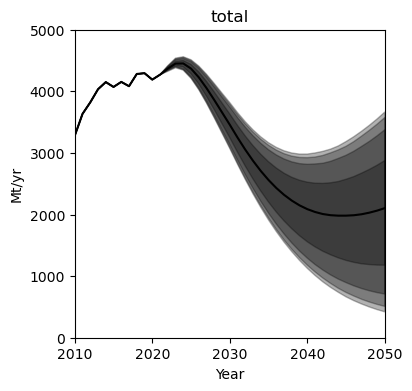

In [5]:
df = pro_percentiles
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    
ax = df[0.5].plot(color='k')
ax.fill_between(df.index, df[0.02], df[0.98], color='k', alpha=0.3)
ax.fill_between(df.index, df[0.05], df[0.95], color='k', alpha=0.3)
ax.fill_between(df.index, df[0.1], df[0.9], color='k', alpha=0.3)
ax.fill_between(df.index, df[0.25], df[0.75], color='k', alpha=0.3)
ax.set_xlim(2010, 2050)
ax.set_ylim(0, 5000)
ax.set_xlabel('Year')
ax.set_ylabel('Mt/yr')
ax.set_title('total')